# Lithology classification using Hugging Face, part 1

- toc: true 
- badges: true
- comments: true
- categories: [hugging-face, NLP, lithology]
- author: J-M


# About

This is (perhaps) the start of a series of posts on using natural language processing for lithology classification. I hope to explore multi-label classification in subsequent posts.

![Courtesy of https://earthresources.vic.gov.au](https://earthresources.vic.gov.au/__data/assets/image/0008/456704/drill_core_library_1.jpg)

# Background

I've been attending virtually the latest Deep Learning course run by [Jeremy Howard](https://jeremy.fast.ai) (See the [fast.ai forum](https://forums.fast.ai) for pointers to past courses). Part of the experience can be to find "homeworks". I traditionally work with point time series data, and it would have been a Pavlov reflex for me to get a use case with this type of data.

However in one of the lessons Jeremy used [Hugging Face](https://huggingface.co/) [Transformers](https://huggingface.co/docs/transformers/index) applied to the Kaggle competition [U.S. Patent Phrase to Phrase Matching](https://www.kaggle.com/competitions/us-patent-phrase-to-phrase-matching). At some point he made a comment about how much NLP progressed over the recent years, and how much potential value creation there was in this.

I do not follow closely NLP research, and am not knowledgeable enough to agree or not, but got an inkling of the potential value a few years back when working on a [python package for exploratory lithology analysis](https://github.com/csiro-hydrogeology/pyela), for groundwater characterisation. Lithology is "the study of the general physical characteristics of rocks". Drilling core soil samples is not cheap; existing records are valuable.

Sections of a core sample drill can be described with sentences such as:

* topsoil
* shale, slippery back, green seams
* sandstone alluvium water bearing
* gravel red very clayey water supply
* sandstone, red/pale brown, fine-coarse, white clay bands, brownish yellow bands, pebbles (16.9-16.98m)
* fill; orange-brown, dry, loose, pebbles to 2.5cm, heterogeneous
* clay; light brown, strongly cohesive, contains silicate & carbonate clasts to coarse sand size, no clay smell.

You would have an inkling that the prose of the writer (the "driller") can vary in style and detail. One typical use case is to determine the primary and (optionally) secondary lithologies of a record, as it strongly influences how fast water can flow underground. "gravel red very clayey" is on the easier side of the spectrum of difficulty: "gravel" as a primary lithology and "clay" as a secondary lithology (assuming these are valid classes for the context). It can get much trickier to classify of course, and certainly expensive if done very manually. Automating this classification process opens the possibility of an iterative process towards a sound lithology classification fit for purpose.

I co-authored a conference presentation "Comparing regular expression and deep learning methods for the classification of descriptive lithology" (Page 161 of the [MODSIM 2019 book of abstracts](https://mssanz.org.au/modsim2019/abstracts.html) if you are curious). With all the caveats of a study made on very limited resources, I was surprised by how well NLP performed overall to train and test on a human-labeled dataset.

I am not working on this domain during paid hours these days, but feel like revisiting this for a bit over the course.

# Getting acquainted with data

Arbitrarily, I downloaded data for the [Namoi catchment](https://www.awe.gov.au/water/cewo/catchment/namoi) from the [Australian Groundwater Explorer](http://www.bom.gov.au/water/groundwater/explorer/map.shtml). While I am not totally new to the domain, I genuinely do need to explore this data from scratch. This will probably be at least the rest of this post.  

In [1]:
import pandas as pd
from pathlib import Path

In [2]:
fn =  Path('~').expanduser() / "data/ela/shp_namoi_river/NGIS_LithologyLog.csv"

The types of a few columns lead to warnings: let's force them to 'str' here. I do not anticipate using the depth records for now. 

In [3]:
litho_logs = pd.read_csv(fn, dtype={'FromDepth': str, 'ToDepth': str, 'MajorLithCode': str, 'MinorLithCode': str})

So how does this data look like?

In [4]:
litho_logs.head()

,OBJECTID,BoreID,HydroCode,RefElev,RefElevDesc,FromDepth,ToDepth,TopElev,BottomElev,MajorLithCode,MinorLithCode,Description,Source,LogType,OgcFidTemp
0,14,10045588,GW003048.1.1,None,UNK,0.0,1.22,None,None,SOIL,NaN,SOIL SANDY CLAY,UNK,1,8666163
1,15,10045588,GW003048.1.1,None,UNK,19.51,28.65,None,None,BSLT,NaN,BASALT WATER BEARING,UNK,1,8666164
2,28,10060509,GW006968.1.1,None,UNK,0.0,3.66,None,None,TPSL,NaN,TOPSOIL,UNK,1,8666177
3,29,10060509,GW006968.1.1,None,UNK,33.53,34.75,None,None,GRVL,NaN,GRAVEL WATER BEARING,UNK,1,8666178
4,30,10060509,GW006968.1.1,None,UNK,48.77,51.82,None,None,SHLE,NaN,SLIPPERY BACK,UNK,1,8666179


A MajorLithoCode column appears to be populated, so this may be suitable for training a classifier. I have no idea (or forgot) how these lithology codes have been derived and what the corpus of labels is. 

In [5]:
len(litho_logs)

144518

For the sake of conciseness I will point-blank reuse the text processing utilities in the ela package, without any explanation of the setup (ela comes with many dependencies from NLP to 3d vis that can be tricky to install).

In [6]:
from ela.textproc import token_freq, plot_freq

In [7]:
MAJOR_CODE='MajorLithCode'
MINOR_CODE='MinorLithCode'
DESC='Description'

## Major (primary) lithology codes

In [8]:
litho_classes=litho_logs[MAJOR_CODE].values
df_most_common= token_freq(litho_classes, 50)

<AxesSubplot:xlabel='token'>

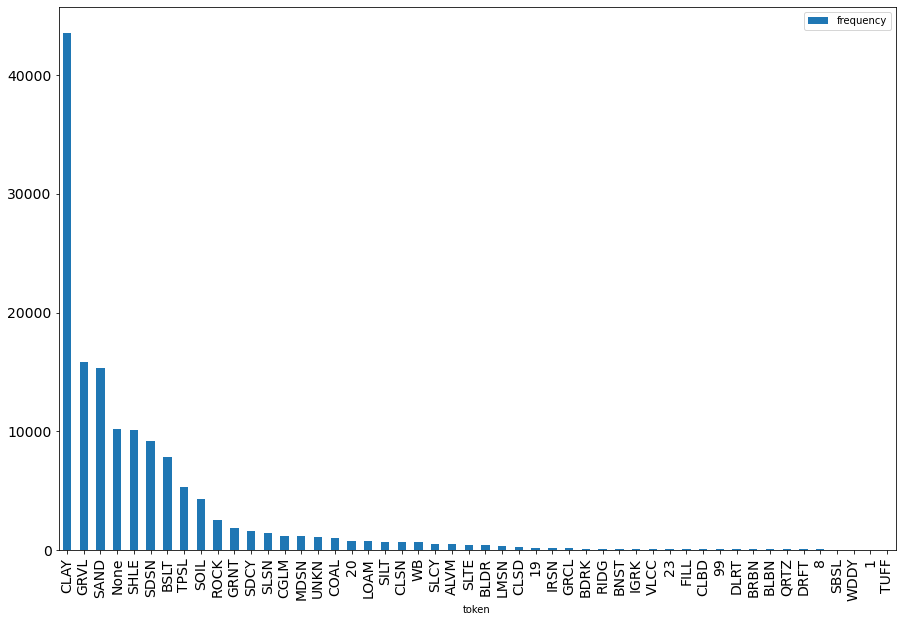

In [9]:
plot_freq(df_most_common)

This is a long-tailed distribution; quite a few labels. The limit to 4 characters labels suggest a form of controlled vocabulary. The numbers 20, 19, 23, 8, 1 look odd. "None" is an artefact though not misleading, quite a few records are such that no major lithology could be attributed. 

## Minor (secondary) lithology codes

In [10]:
litho_classes=litho_logs[MINOR_CODE].values
df_most_common= token_freq(litho_classes, 50)

<AxesSubplot:xlabel='token'>

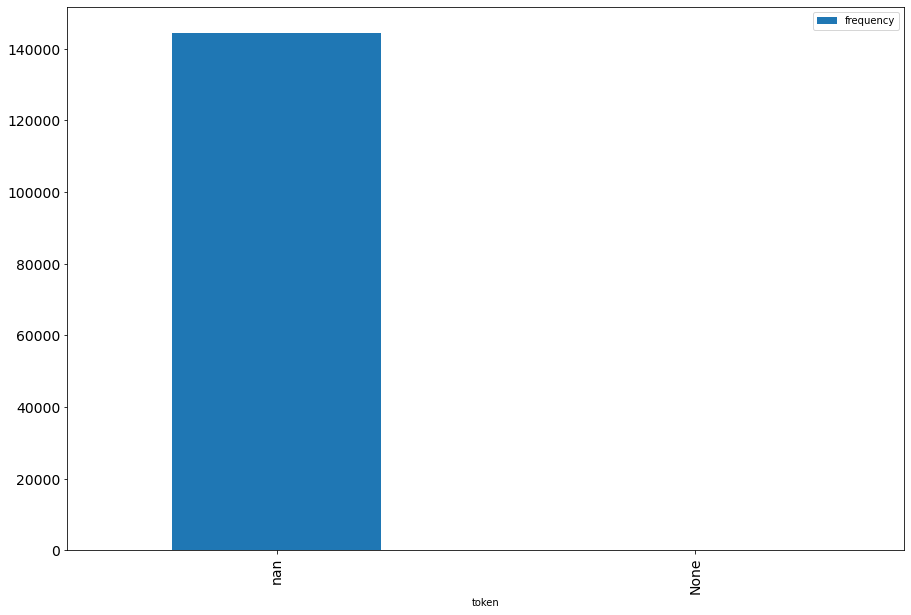

In [11]:
plot_freq(df_most_common)

Well, no minor lithology codes, so this data set may not be a good start for multi-label classification. Still, I'll persist with this data set, and reassess later on

## Back to major lithology codes

What are the flavour of descriptions leading to the most frequent classes (CLAY, GRVL, etc.), as well as "None" 

In [12]:
is_clay = litho_logs[MAJOR_CODE] == 'CLAY'

In [13]:
clay_coded = litho_logs.loc[is_clay][DESC]

In [14]:
import numpy as np
np.random.seed(123)
clay_coded.sample(n=50)

144320                                                 CLAY
117387                                                 CLAY
18630                                                  CLAY
35565                                       CLAY SOME SANDY
61997                                                  CLAY
13533                                  CLAY SANDSTONE BANDS
117529                                          YELLOW CLAY
82290                                                  CLAY
73280                                       CLAY GREY SANDY
106748                                          CLAY STONEY
26265                                           CLAY YELLOW
16456                                                  CLAY
25032                                                  CLAY
9911                                                   CLAY
135852    CLAY, SANDY GRAVELLY, ORANGE BROWN, MEDIUM PLA...
30596                                                  CLAY
140698    CLAY, SANDY FAT; RED, DRY-MOIS

Nothing too surprising in this, very intuitive, though the tail suggests there may be a few outliers:

In [15]:
clay_coded.tail(10)

144386            CLAY; LIGHT BROWN, SOME LIGHT GREY, SILTY
144388                                          CLAY; BROWN
144391                                    CLAY; LIGHT BROWN
144393                                         CLAY - BROWN
144394         CLAY - LIGHT BROWN, EXTREMELY SANDY (COARSE)
144398    CONGLOMERATE - WEATHERED BUT STILL HOLDS TOGET...
144401                                          CLAY; BROWN
144402                                          CLAY - GREY
144488                                                 CLAY
144503                                                 None
Name: Description, dtype: object

Looking at the "sand" code:

In [16]:
def sample_desc_for_code(major_code, n=50, seed=None):
    is_code = litho_logs[MAJOR_CODE] == major_code
    coded = litho_logs.loc[is_code][DESC]
    if seed is not None:
        np.random.seed(seed)
    return coded.sample(n=50)

In [17]:
sample_desc_for_code('SAND', seed=123)

72256                         SAND GRAVEL FINE WATER SUPPLY
109345                                   SAND CLAYEY GRAVEL
66816                                     SAND WATER SUPPLY
85097     SAND - 70% UP TO 2MM, GRAVEL 10% 2-5MM, CLAY 2...
137476    SAND; LIGHT BROWN, MEDIUM TO COARSE, FINE GRAV...
29946                                     SAND GRAVEL DIRTY
37012                                COARSE SAND AND GRAVEL
135985                                                 SAND
74402              SAND WHITE GREY WELL SORTED WATER SUPPLY
42422                                           SAND GRAVEL
41225                                    SAND CLAYEY GRAVEL
50700                                                  SAND
33813                      BROWN SAND (VERY FINE TO MEDIUM)
38452                       SAND GRAVEL MEDIUM WATER SUPPLY
107707                                     SAND FINE-COARSE
51759     SAND; 60%, SILTY, FINE 10%, MEDIUM 20% & COARS...
102234                             SAND 

Rather straighforward, consistent and and intuitive

### Major lithology code "None"

This one is likely to be more curly and surprising. Let's see


In [18]:
sample_desc_for_code('None', seed=123)

131075                            W.B. BROWN SHALE
127170                      COARSE SAND AND GRAVEL
126145                                   BLUE CLAY
126889                         GREY AND BROWN CLAY
132179                             GREY BROWN CLAY
130033                            BROWN SANDY CLAY
123436                                      GRAVEL
128794                                        CLAY
128242                        SAND AND FINE GRAVEL
134156                                        None
129636                                 W.B. BASALT
122884                     LIGHT ORANGE SILTY CLAY
124580                                      SHALES
128684                                  W.B. SHALE
131120                             SAND AND GRAVEL
122690                              RED RIDGE CLAY
132319                                  BLACK SOIL
128528                                  BLACK CLAY
123646                                    MUDSTONE
129757                         

Well, it does not require a fully trained geologist to think there should be obvious primary lithology codes for many of these, so why is there "None" for these descriptions?

Not shown in the 50-odd sample above are descriptions which should indeed be unclassified (e.g. "no strata description")

This is also an occasion to note the less obvious information and complications in descriptive logs, compared to earlier categories:
  
* CALY as a typo for CLAY
* Slang terms and acronyms, e.g. "W.B." perhaps for "Weathered, broken"  
* Quantitative and qualitative attributes such as SAND; 60%, SILTY, FINE 10%, MEDIUM 20% & COARSE, which may be valuable for some types of classification 


In [19]:
sample_desc_for_code('SDSN', seed=123)

9423                                         SANDSTONE SOFT
117911            SANDSTONE, SILTY; AS ABOVE, QUARTZ (+60%)
6613                                         SAND ROCK GREY
20345                                   SANDSTONE GREY HARD
106885                                            SANDSTONE
139088           SANDSTONE; DARK GREY, COARSE GRAINED, HARD
5101                                       SANDSTONE ROTTEN
26561                                      SANDSTONE YELLOW
137304                                    SANDSTONE; COARSE
56627     SANDSTONE; GREY, FINE-MEDIUM GRAINED, MOD WEAK...
98974                          SANDSTONE WHITE WATER SUPPLY
87187                                             SANDSTONE
45141                 SANDSTONE, VERY PALE BROWN, HIGH CLAY
70015                                      SANDSTONE YELLOW
29492                                SANDSTONE WATER SUPPLY
92918                                             SANDSTONE
83555              SANDSTONE; LIGHT GREY

Now, what's with the weird numbers as lithology codes?

In [20]:
sample_desc_for_code('20', seed=123)

130369                           SANDY CLAY; BROWN (COARSE)
122444                                           CLAY SANDY
127761                                           CLAY SANDY
125771                                           SANDY CLAY
127783                                           CLAY SANDY
133014                SANDY CLAY AND CLAYEY SAND AND GRAVEL
124007                              BROWN & GREY SANDY CLAY
123445     CLAY LT BROWN GREY SANDY, MED-COARSE BROWN BANDS
122180                                           CLAY SANDY
127440                                           SANDY CLAY
131498                                           SANDY CLAY
127935                                       CLAY RED SANDY
129304                                           SANDY CLAY
130614                                          SANDY SHALE
125543                                           SANDY CLAY
125149                                           SANDY CLAY
124971                                SA

Interesting. There is a clear pattern. I know from my prior exposure that "Clayey sands" and "sandy clays" are not that uncommon (and gradations of mixes of sand and clay matter a great deal to estimate hydraulic conductivity).

## Next

This was the initial EDA. Next I'll  probably train a classifier on the major lithology code (or a subset thereof). I am keen to explore multi-label classification, but will have to decide whether to populate the secondary lithology code using regexp classification, or switch to a fully labelled dataset at some point.

This first post illustrated the need to have a look at data. This data was already collated and curated, and I have no doubt many people went through a lot of work to get there. But this may not be a fully labelled dataset amenable to be used for training a classifier. At least, not without further data preparation.